# Simulated annealing - Traveling salesman
Author: **Jakub Kosmydel**
### Load libraries

In [1]:
import math

import numpy as np
import matplotlib.pyplot as plt
import random

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = [16, 9]

from IPython.display import display, HTML
from matplotlib.animation import FuncAnimation
from datetime import datetime
from matplotlib.gridspec import GridSpec
from tqdm import tnrange
from matplotlib.gridspec import GridSpec

np.random.seed(1337)

### Annealing result

In [2]:
class AnnealingData:
    def __init__(self, solution, solution_energy, states_hist, temp_hist, energy_hist):
        self.solution = solution
        self.solution_energy = solution_energy
        self.states_hist = states_hist
        self.temp_hist = temp_hist
        self.energy_hist = energy_hist

### Annealing function

In [3]:
def annealing(data, initial_temp=10, steps=100, modifier_temp=0.99, is_random_neighbour=True, animation_frames=100):
    n = len(data)
    def neighbour(state, temp):
        res = state.copy()
        changes = math.ceil(temp)
        if is_random_neighbour:
            sample = random.sample(s, 2*changes)
            for a in range(changes):
                i, j = sample[2*a], sample[2*a+1]
                res[i], res[j] = res[j], res[i]
        else:
            sample = random.sample(s, changes)
            for a in sample:
                shift = np.random.randint(math.ceil(temp+1)) + 1
                res[a], res[(a+shift)%n] = res[(a+shift)%n], res[a]

        return res
    
    def energy(state):
        def distance(p1, p2):
            return np.linalg.norm(p1-p2)
        
        res = 0
        for i in range(n):
            res += distance(data[state[i]], data[state[(i+1)%n]])
        return res    
    
    def P(E, E1, T):
        if E1 < E: return 1.
        return np.exp(-(E1-E)/T)
    
    s = [_ for _ in range(n)]
    random.shuffle(s)
    min_energy = float('inf')
    min_energy_s = s
    T = initial_temp
    energy_y = [None] * steps
    temp_y = [None] * steps

    states_history = [None] * animation_frames

    for k in tnrange(steps):
        
        T *= modifier_temp
        s_new = neighbour(s, T)
        e = energy(s)
        e1 = energy(s_new)
        energy_y[k] = e
        temp_y[k] = T

        if k % (steps // animation_frames) == 0:
            states_history[k // (steps // animation_frames)] = (s, k, e, T)

        if e1 < min_energy:
            min_energy = e1
            min_energy_s = s_new
            
        if P(e, e1, T) >= np.random.uniform(0, 1):
            s = s_new

    return AnnealingData(solution=min_energy_s,
                         solution_energy=min_energy,
                         states_hist=states_history,
                         temp_hist=temp_y,
                         energy_hist=energy_y)

### Testing data
#### Function to plot solution

In [4]:
def plot_tsm(graph_data, annealing_data):
    n = len(graph_data)
    solution = annealing_data.solution

    fig1 = plt.figure(constrained_layout=True, figsize=(9, 6), dpi=256)
    gs = GridSpec(2, 3, figure=fig1)
    ax1 = fig1.add_subplot(gs[:, :2])
    ax2 = fig1.add_subplot(gs[0, 2])
    ax3 = fig1.add_subplot(gs[1, 2])

    x, y = graph_data.T
    for i in range(n):
        i1 = solution[i]
        i2 = solution[(i+1)%n]
        ax1.plot([x[i1], x[i2]], [y[i1], y[i2]], 'ro-')

    space_x = [x for x in range(len(annealing_data.energy_hist))]
    ax2.set_ylabel('Energy')
    ax2.scatter(space_x, annealing_data.energy_hist, s=0.05)
    ax3.set_ylabel('Temperature')
    ax3.scatter(space_x, annealing_data.temp_hist, s=0.05)
    plt.show()

#### TSP annealing animation
It saves the result to gif.

In [5]:
%matplotlib notebook

def animate_tsp(graph_data, annealing_data, name="animation"):
    n = len(graph_data)
    figure, axis = plt.subplots(figsize=(5, 5), dpi=300)
    states_history = annealing_data.states_hist

    fig, plot1 = plt.subplots()

    x, y = graph_data.T

    def update(idx):
        solution, k, e, T = states_history[idx]
        axis.clear()
        for i in range(n):
            i1 = solution[i]
            i2 = solution[(i+1)%n]
            axis.plot([x[i1], x[i2]], [y[i1], y[i2]], 'ro-')

        axis.text(0, 0, f'#{idx}',
                    fontsize=12, horizontalalignment='left',
                    verticalalignment='bottom', transform=axis.transAxes)
        axis.text(0.25, 0, f'k: {k:}',
                    fontsize=12, horizontalalignment='left',
                    verticalalignment='bottom', transform=axis.transAxes)
        axis.text(0.5, 0, f'e: {e:.1f}',
                    fontsize=12, horizontalalignment='left',
                    verticalalignment='bottom', transform=axis.transAxes)
        axis.text(0.75, 0, f'T: {T:.3f}',
                    fontsize=12, horizontalalignment='left',
                    verticalalignment='bottom', transform=axis.transAxes)
        return [plot1]

    def init():
        return [plot1]

    animation = FuncAnimation(figure, update, init_func=init, frames=len(states_history), interval=50, repeat_delay=1000)
    now = datetime.now()
    filename = f'./tsp/{name}-{now.strftime("%d_%m_%Y-%H-%M-%S")}.gif'
    animation.save(filename, writer='pillow', fps=30)

#### Generate distributions

In [6]:
data_1 = np.random.uniform(0, 1.0, size=(10, 2))
data_2 = np.random.uniform(0, 1.0, size=(30, 2))
data_3 = np.random.uniform(0, 1.0, size=(50, 2))
data_n = np.random.normal(0, 1.0, size=(20, 2))

def generate_groups(n=9, group_size=8, groups_range=10, std_in_group=2):
    res = np.empty([n*group_size, 2])
    for i in range(n):
        x, y = (i % 3)*10, (i//3)*10
        to_add = np.random.normal(0, 1, size=(group_size, 2))
        to_add += np.array([x, y])
        res[i*group_size : (i+1)*group_size, :] = to_add
    return res

data_g_9 = generate_groups()

##### Uniform distribution, n=10

In [7]:
output1 = annealing(data_1, 5, 10000, modifier_temp=0.999)
print('Found solution with energy: \t', output1.solution_energy)

d:\studia\semestr4\mownit\venv\lib\site-packages\ipykernel_launcher.py:42: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


  0%|          | 0/10000 [00:00<?, ?it/s]

Found solution with energy: 	 2.6610643759307084


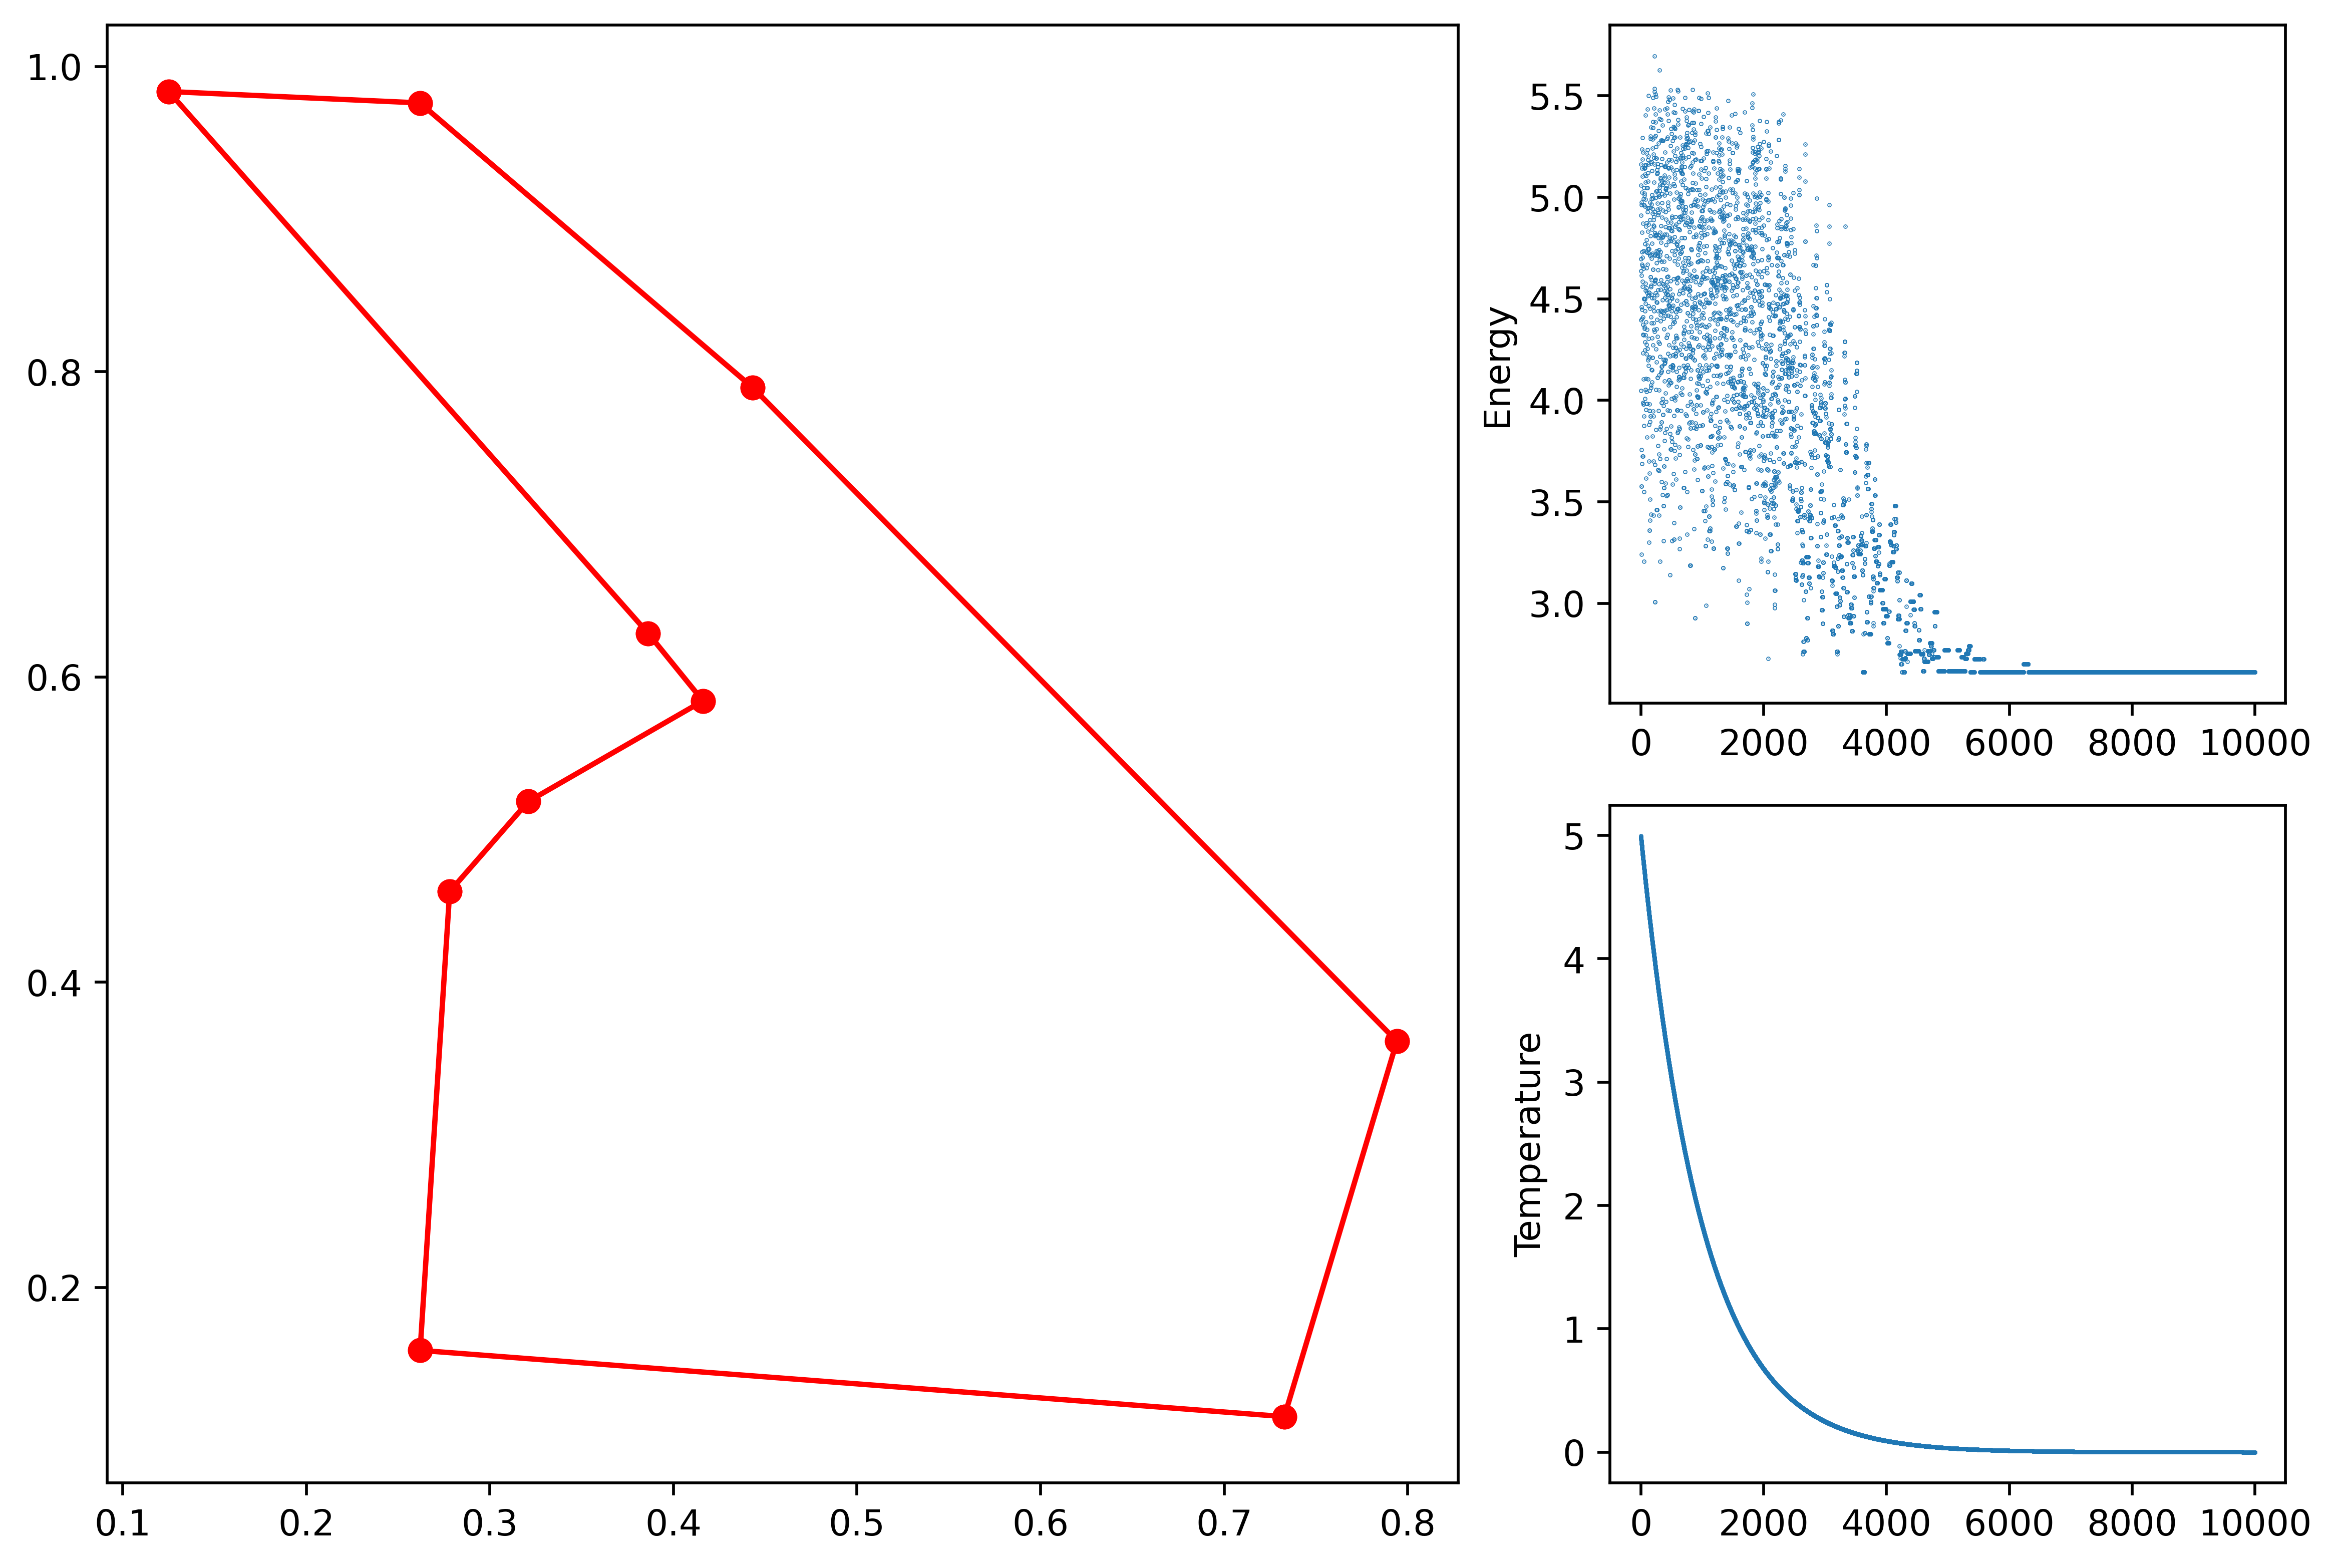

In [8]:
%matplotlib inline
plot_tsm(data_1, output1)

##### Uniform distribution, n=30

In [9]:
output2 = annealing(data_2, 15, 100000, modifier_temp=0.9998)
print('Found solution with energy: \t', output2.solution_energy)

d:\studia\semestr4\mownit\venv\lib\site-packages\ipykernel_launcher.py:42: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


  0%|          | 0/100000 [00:00<?, ?it/s]

Found solution with energy: 	 4.9438937493778266


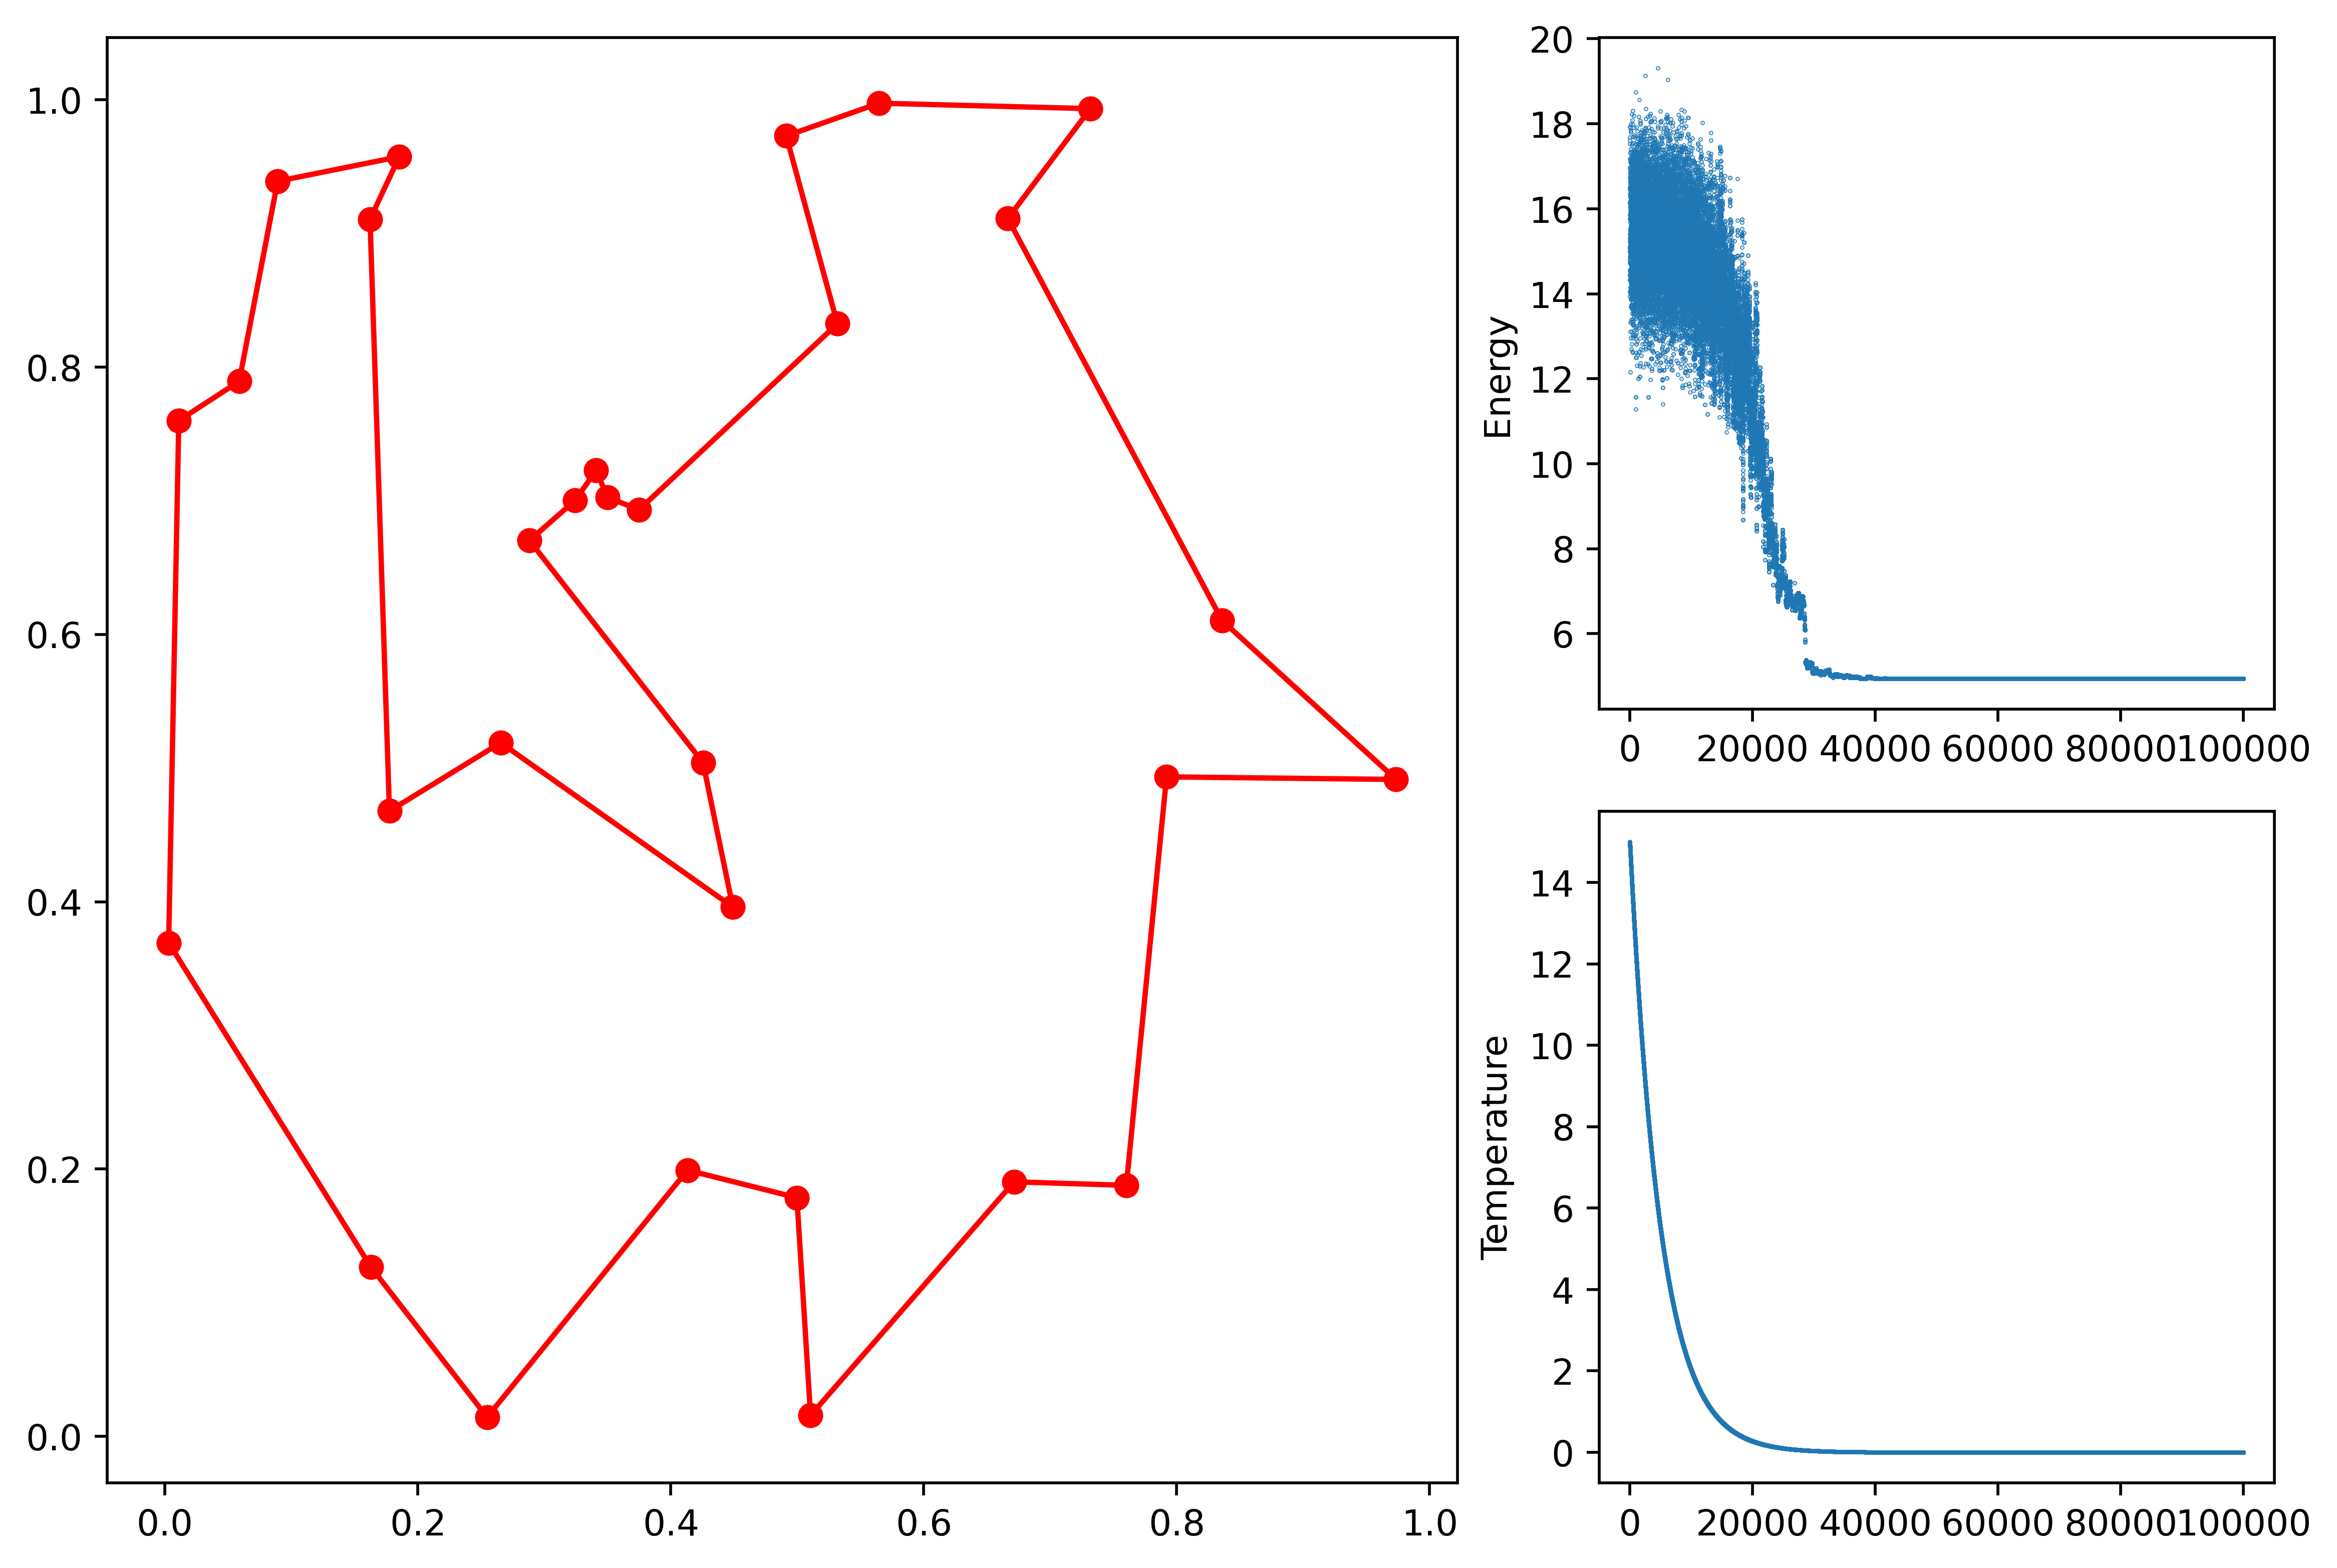

In [10]:
%matplotlib inline
plot_tsm(data_2, output2)

##### Uniform distribution, n=50

In [11]:
output21 = annealing(data_3, 15, 200000, modifier_temp=0.9999)
print('Found solution with energy: \t', output2.solution_energy)

d:\studia\semestr4\mownit\venv\lib\site-packages\ipykernel_launcher.py:42: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


  0%|          | 0/200000 [00:00<?, ?it/s]

Found solution with energy: 	 4.9438937493778266


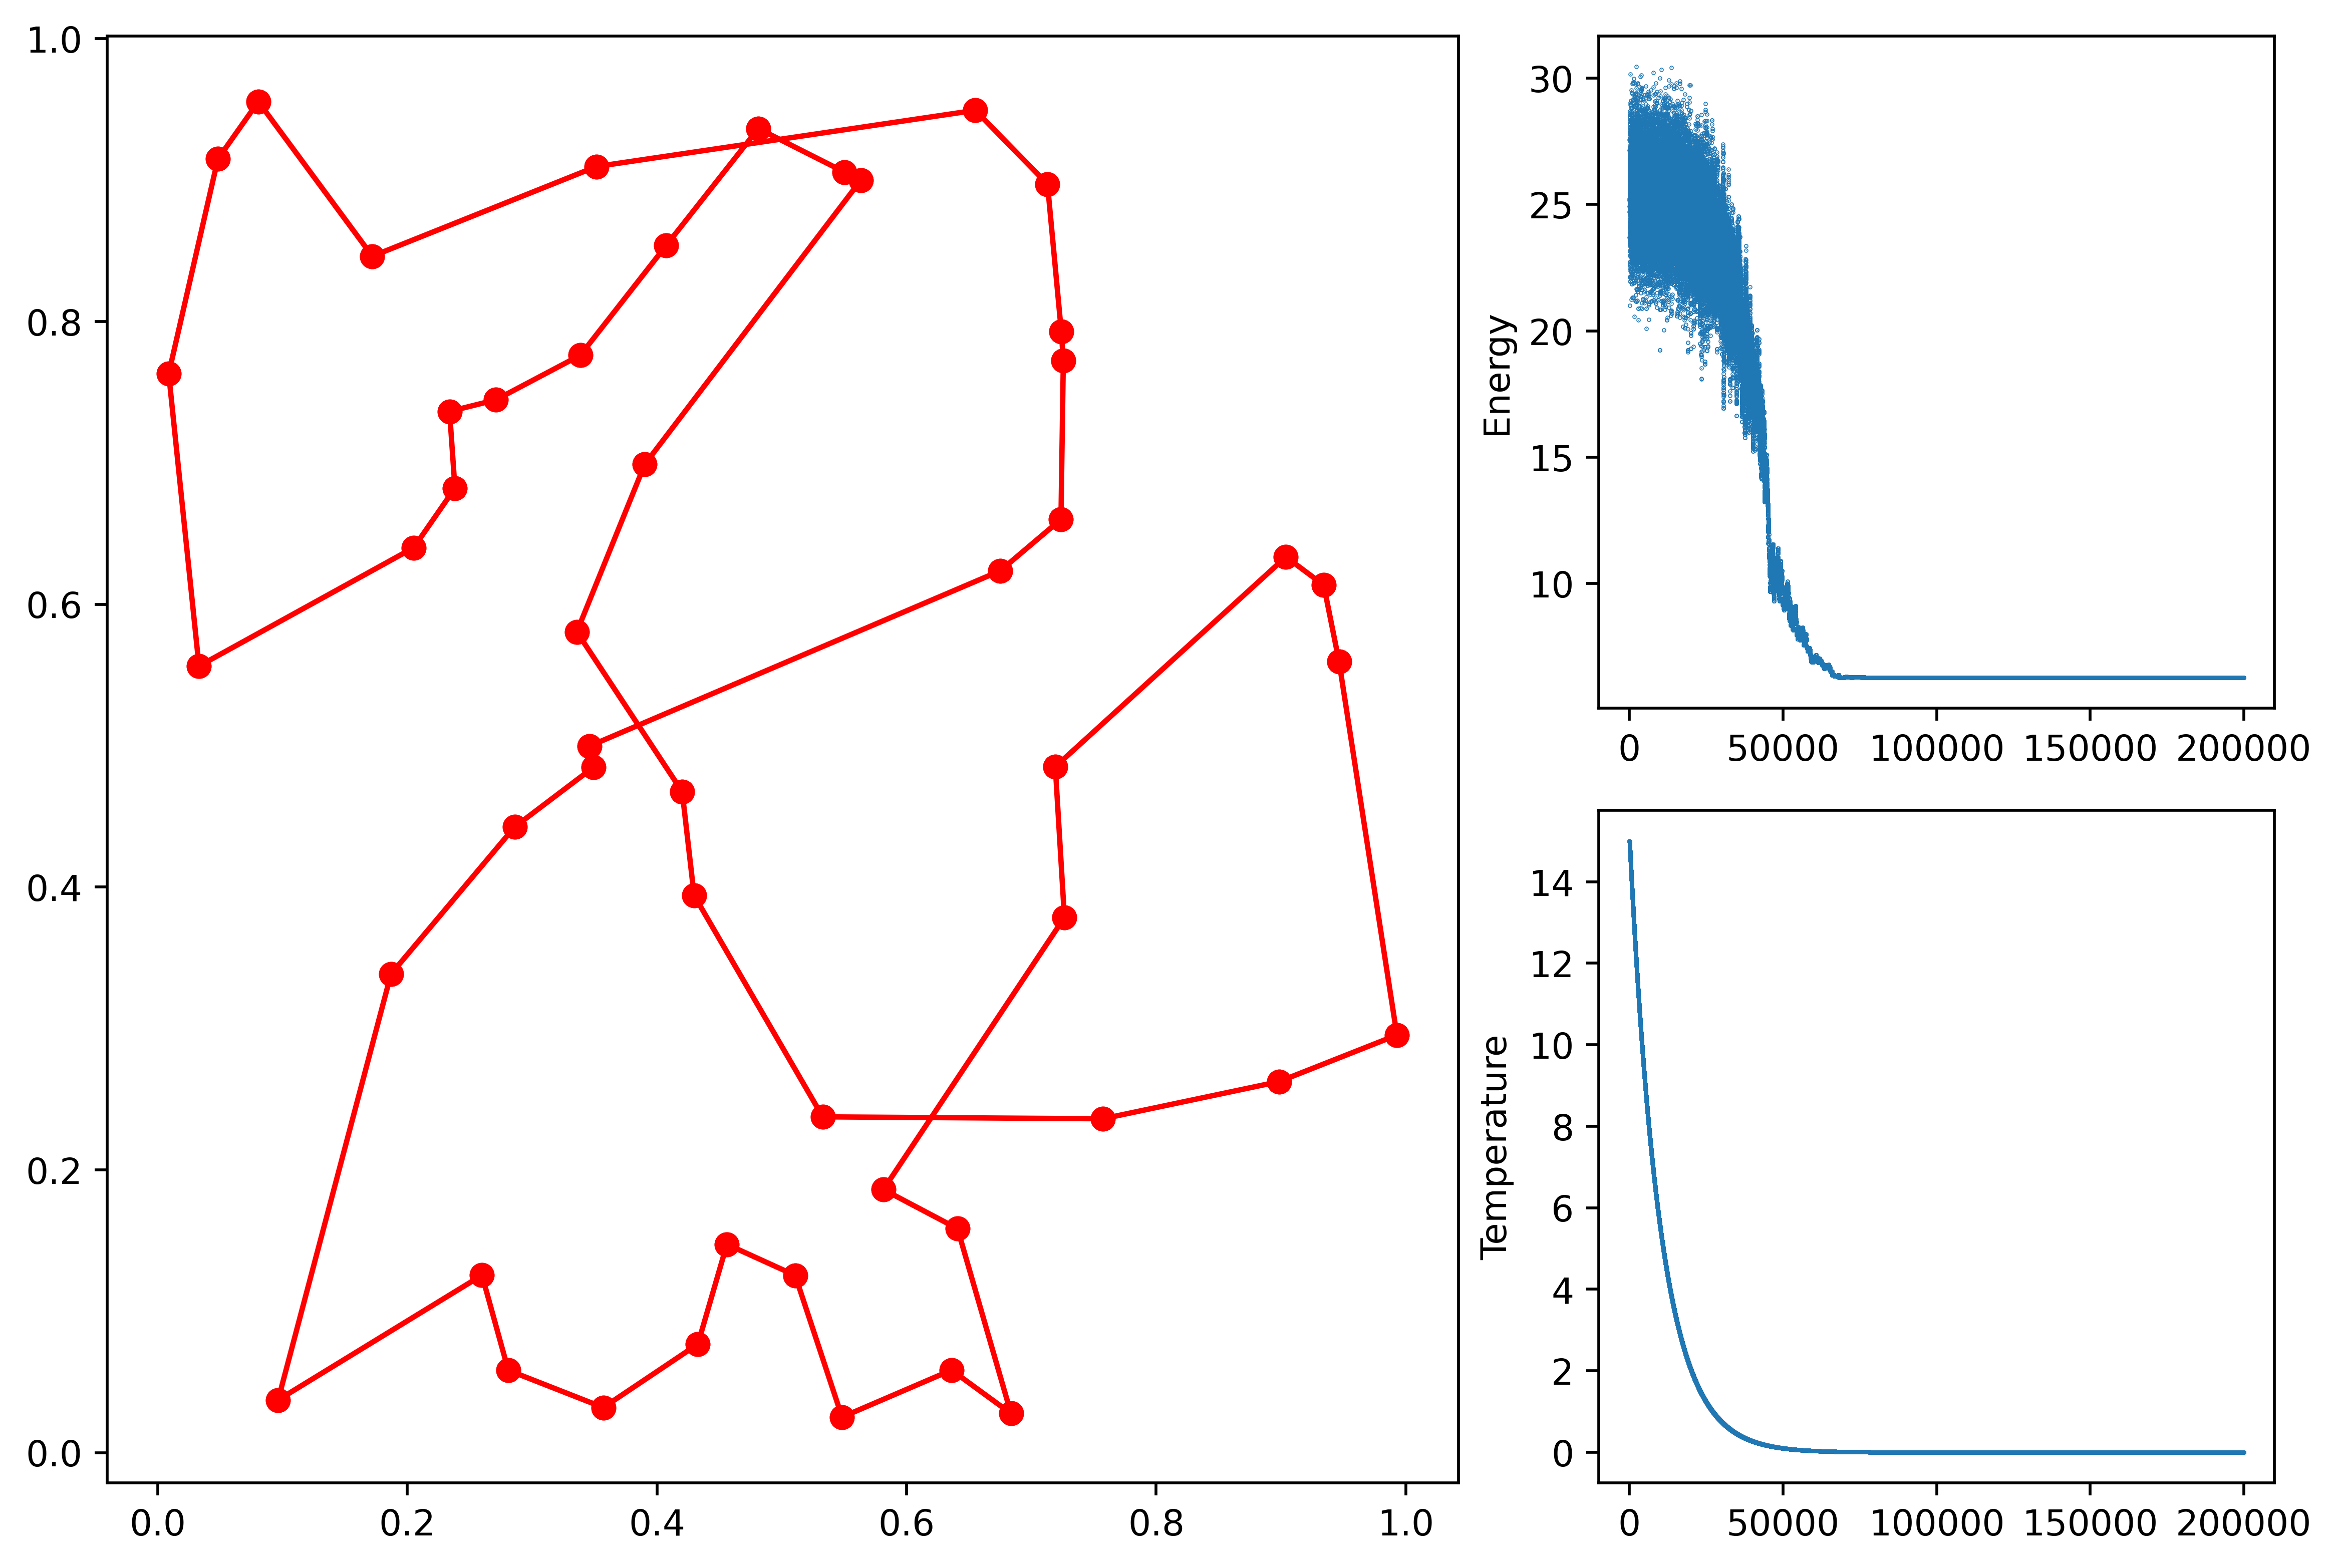

In [12]:
%matplotlib inline
plot_tsm(data_3, output21)

#### Normal distribution, n=20, std=1

In [13]:
output3 = annealing(data_n, 10, 50000, modifier_temp=0.9995)
print('Found solution with energy: \t', output3.solution_energy)

d:\studia\semestr4\mownit\venv\lib\site-packages\ipykernel_launcher.py:42: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


  0%|          | 0/50000 [00:00<?, ?it/s]

Found solution with energy: 	 16.045904524492613


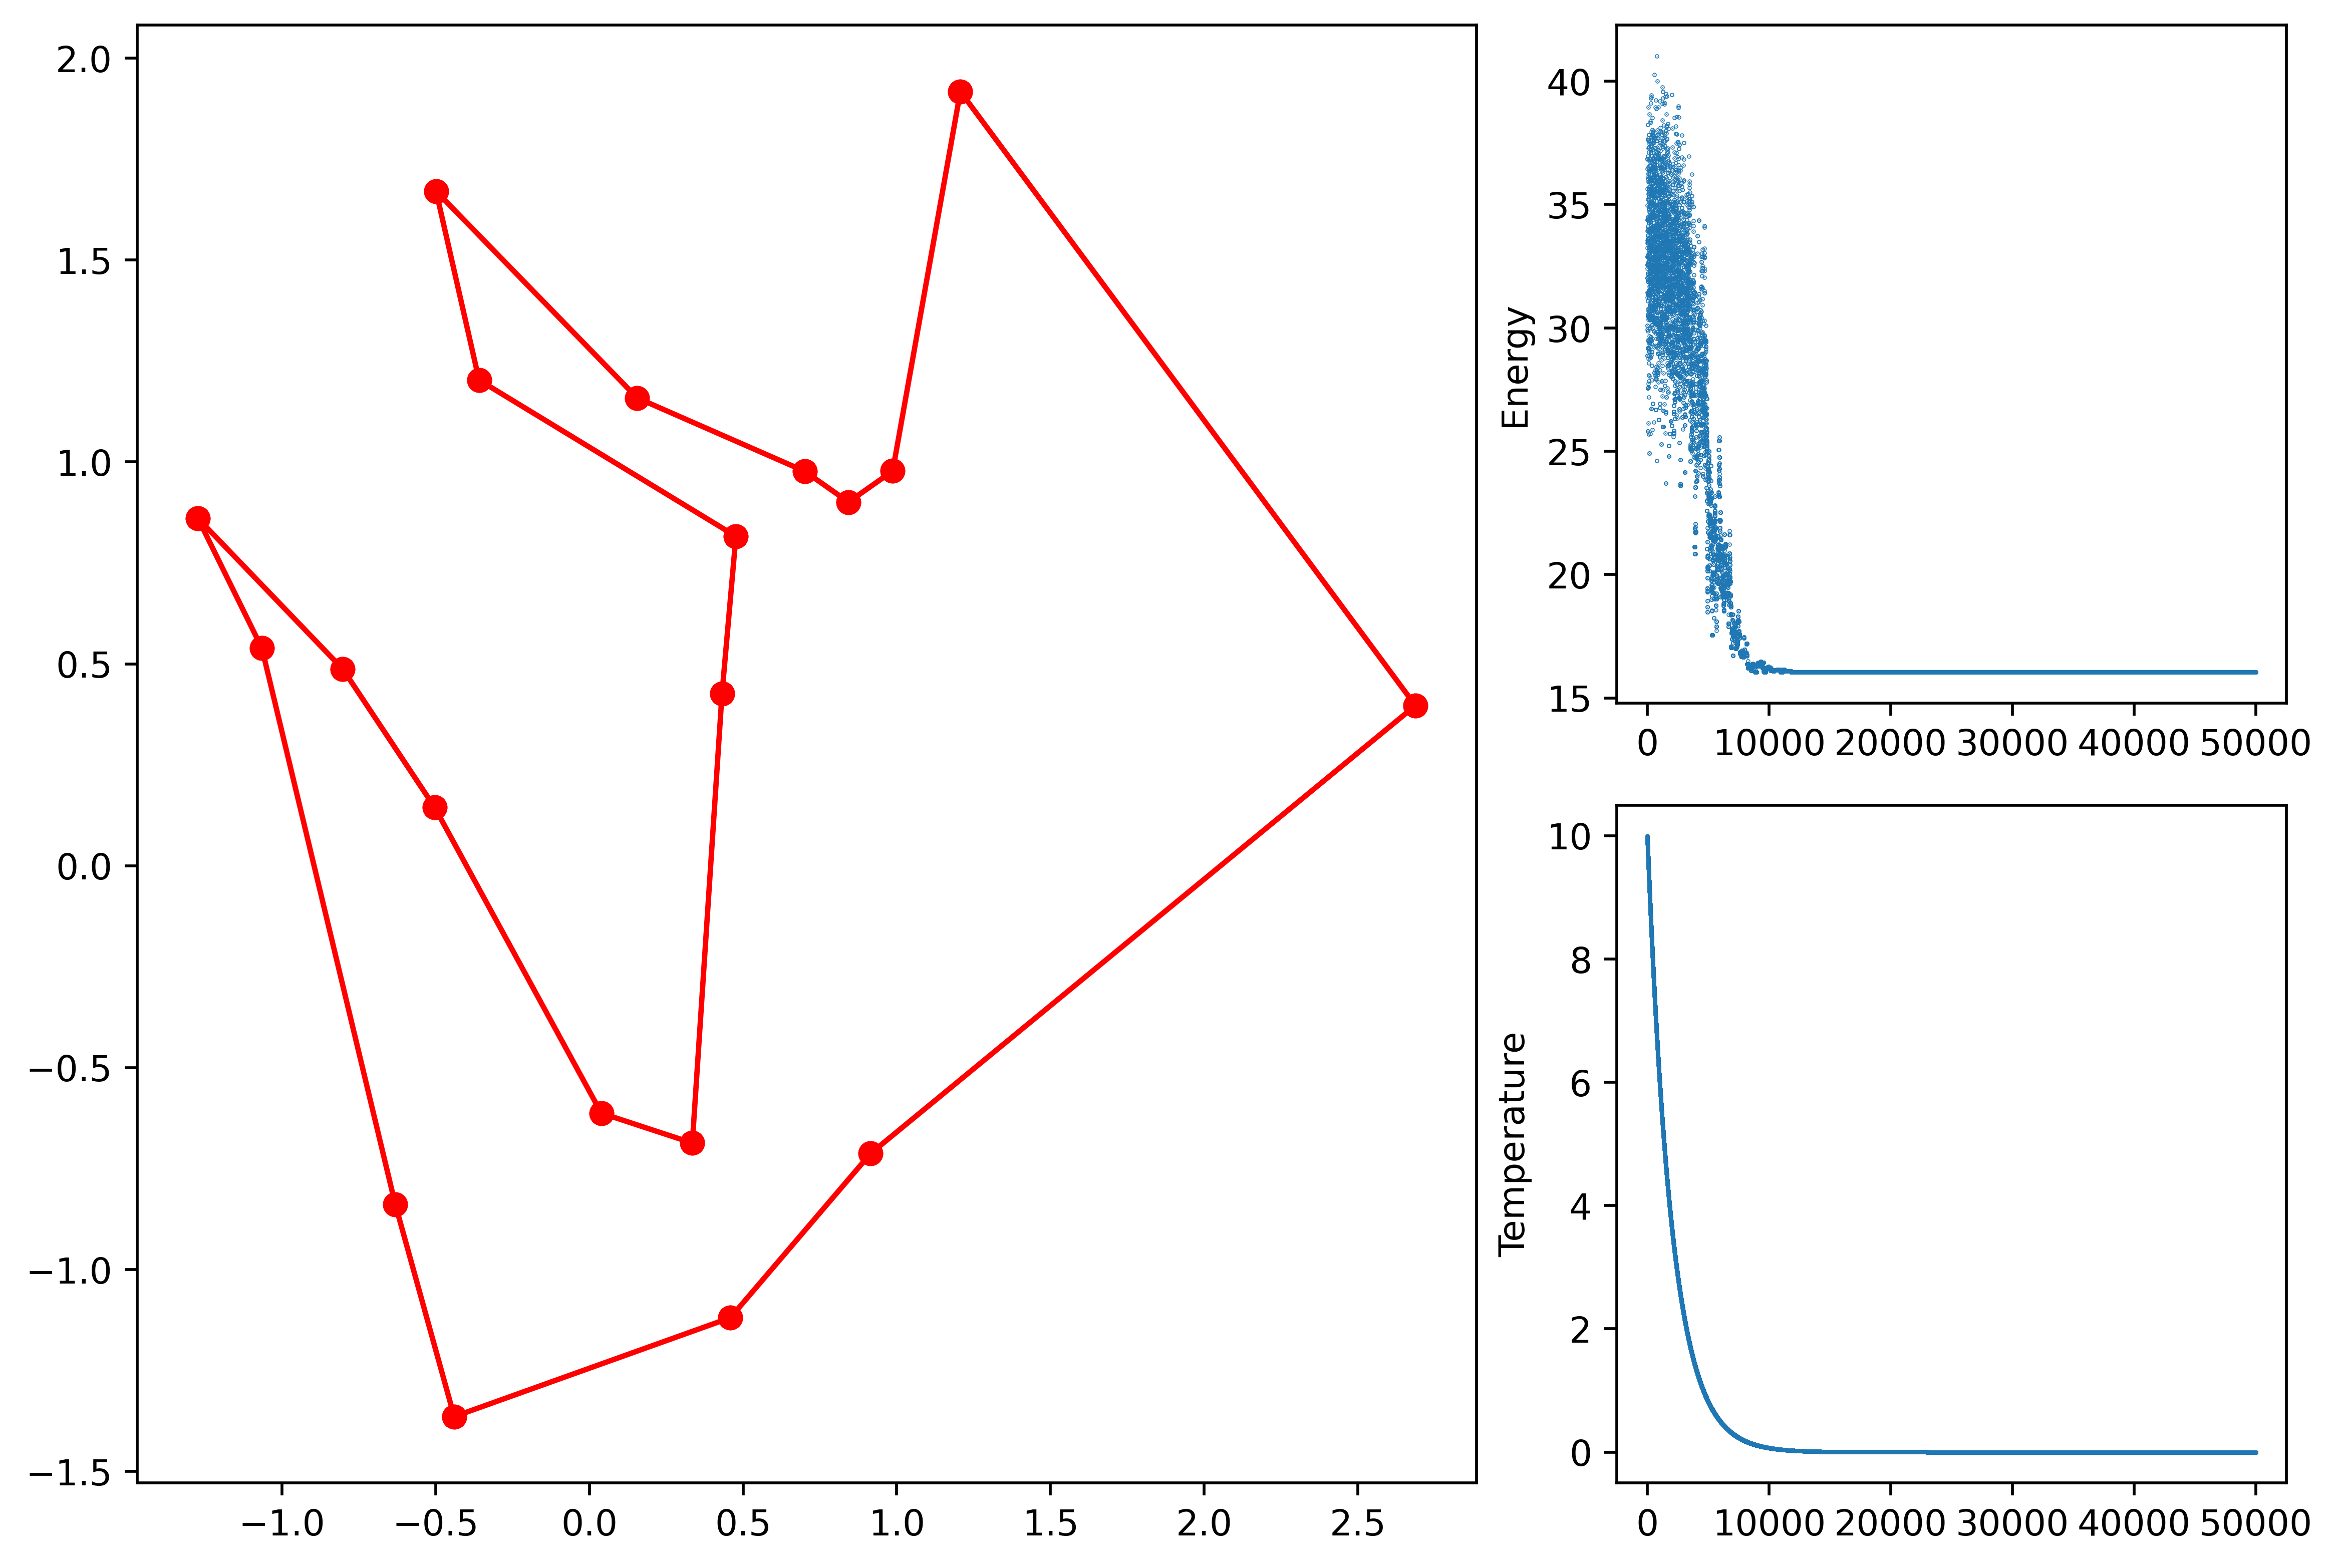

In [14]:
%matplotlib inline
plot_tsm(data_n, output3)

#### Random groups

In [15]:
output4 = annealing(data_g_9, 35, 250000, modifier_temp=0.99995, animation_frames=200)
print('Found solution with energy: \t', output4.solution_energy)

d:\studia\semestr4\mownit\venv\lib\site-packages\ipykernel_launcher.py:42: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


  0%|          | 0/250000 [00:00<?, ?it/s]

Found solution with energy: 	 222.12387840728448


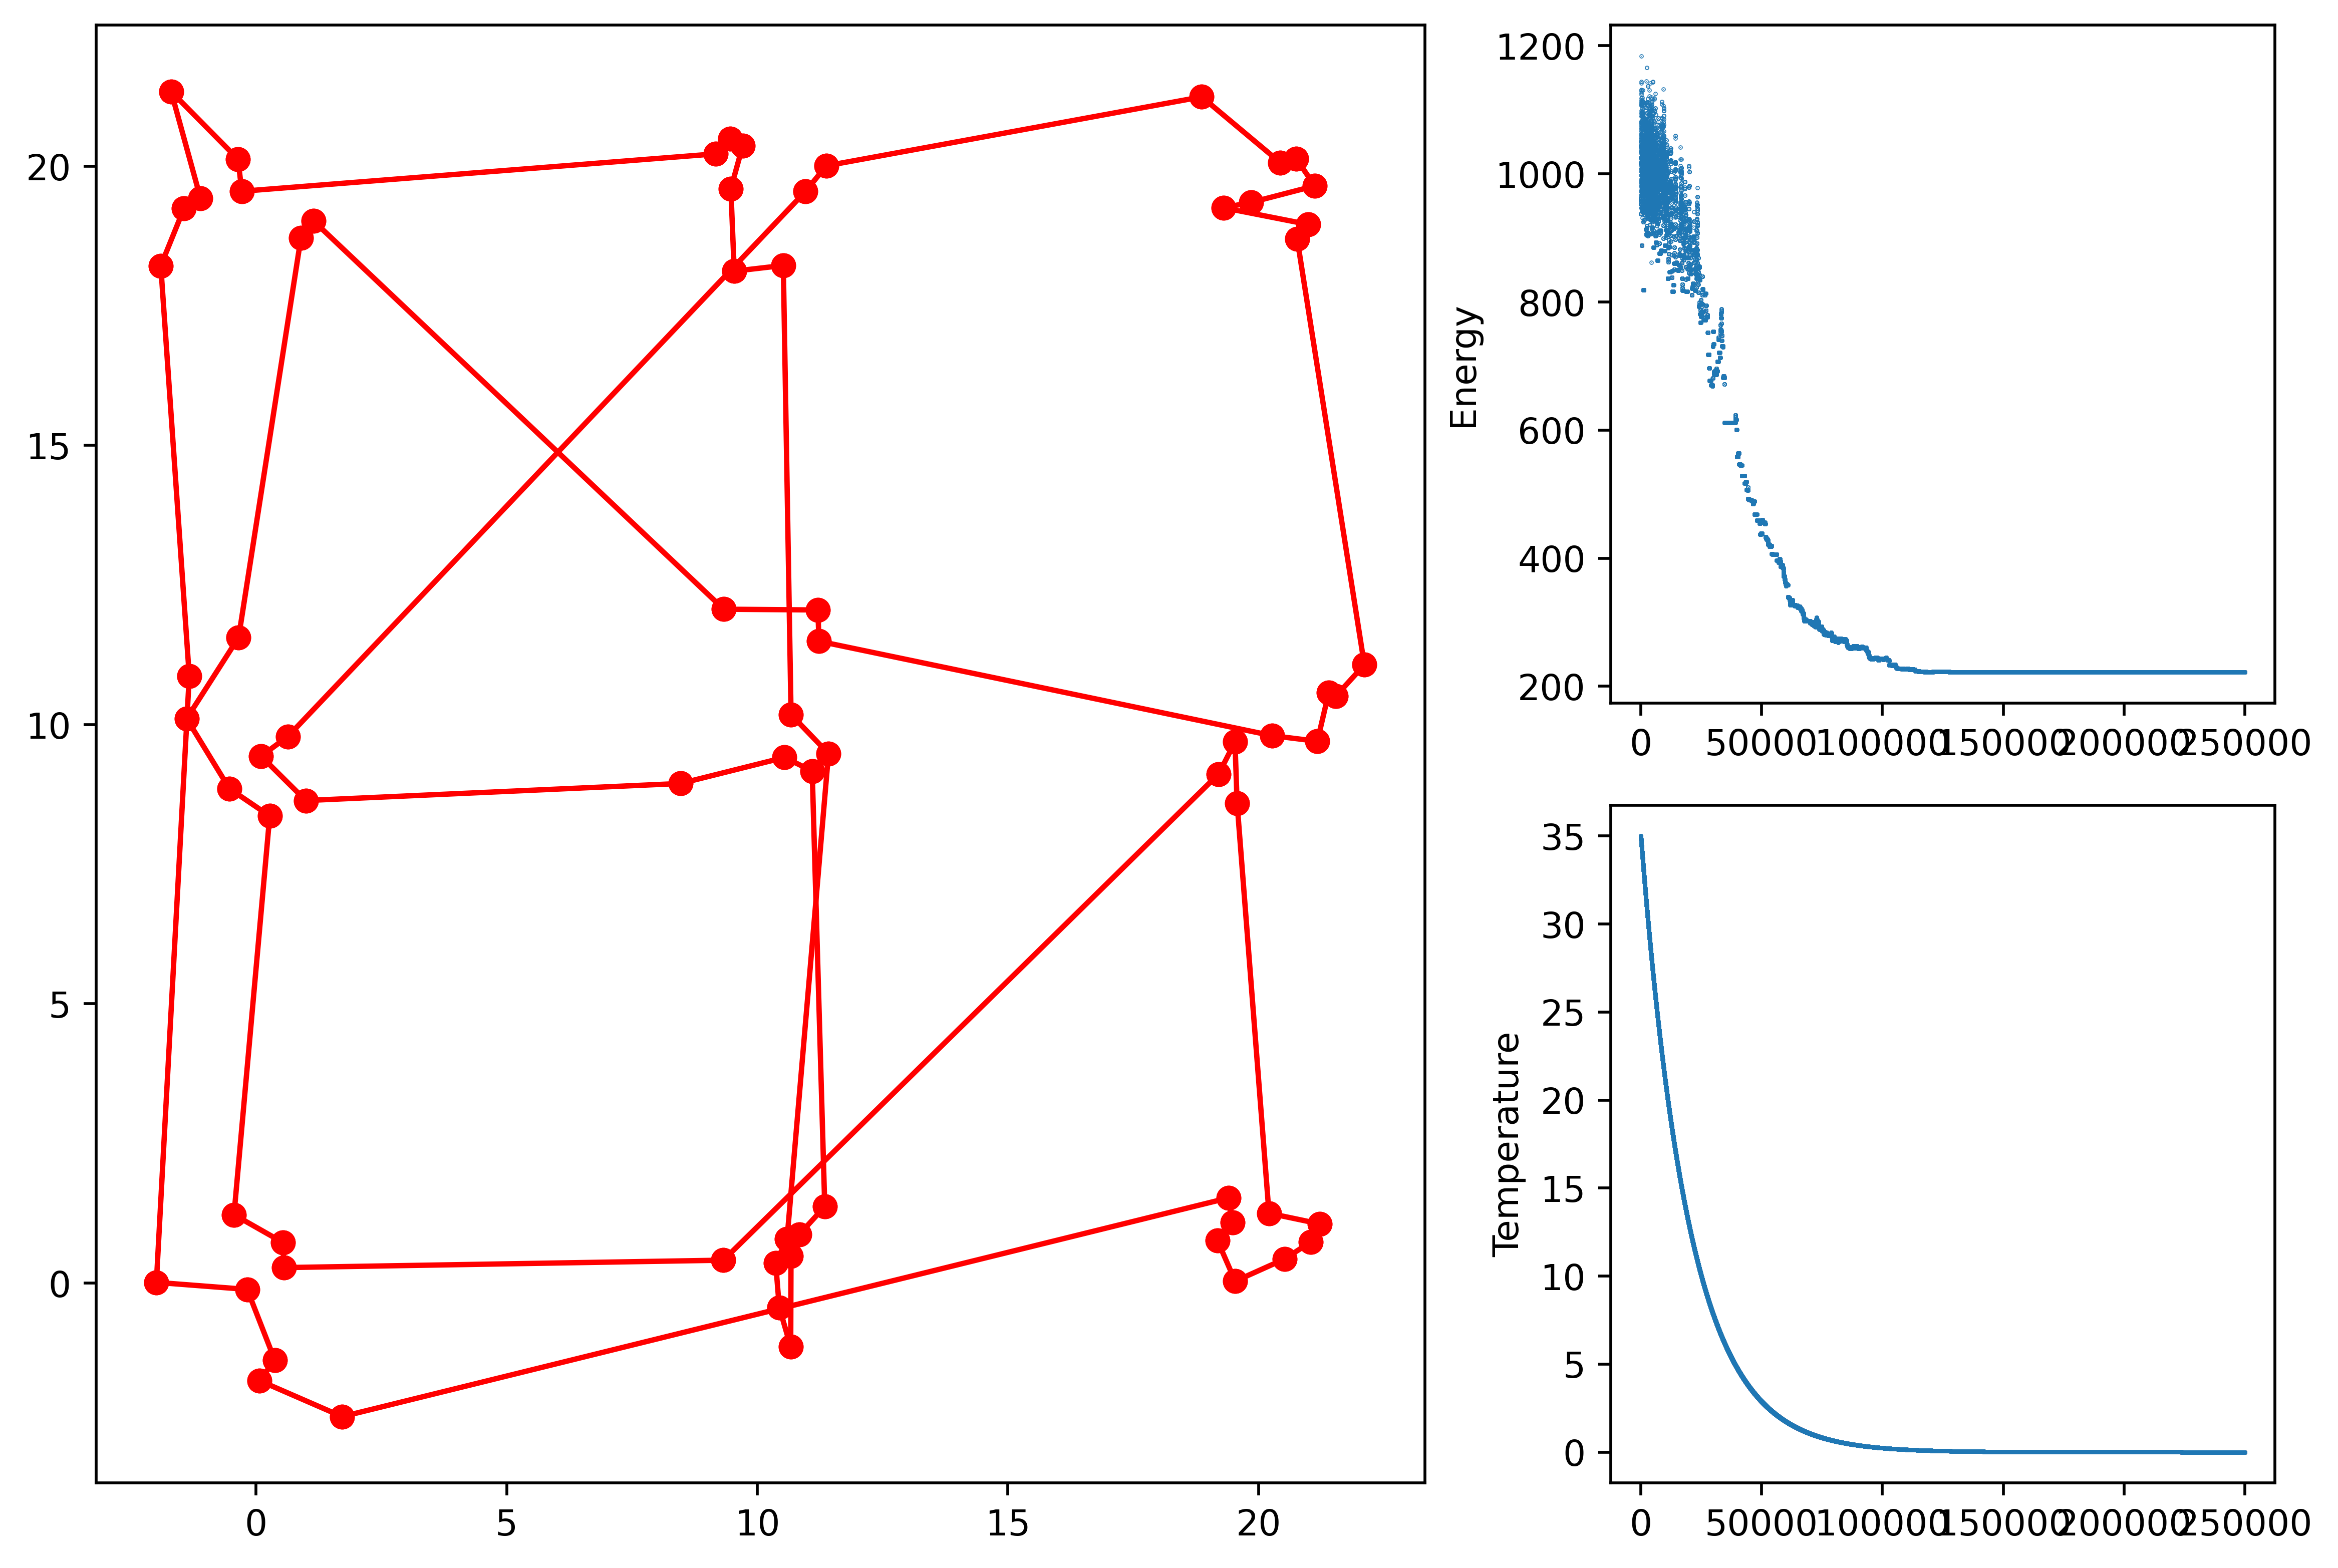

In [16]:
%matplotlib inline
plot_tsm(data_g_9, output4)

### Save animations

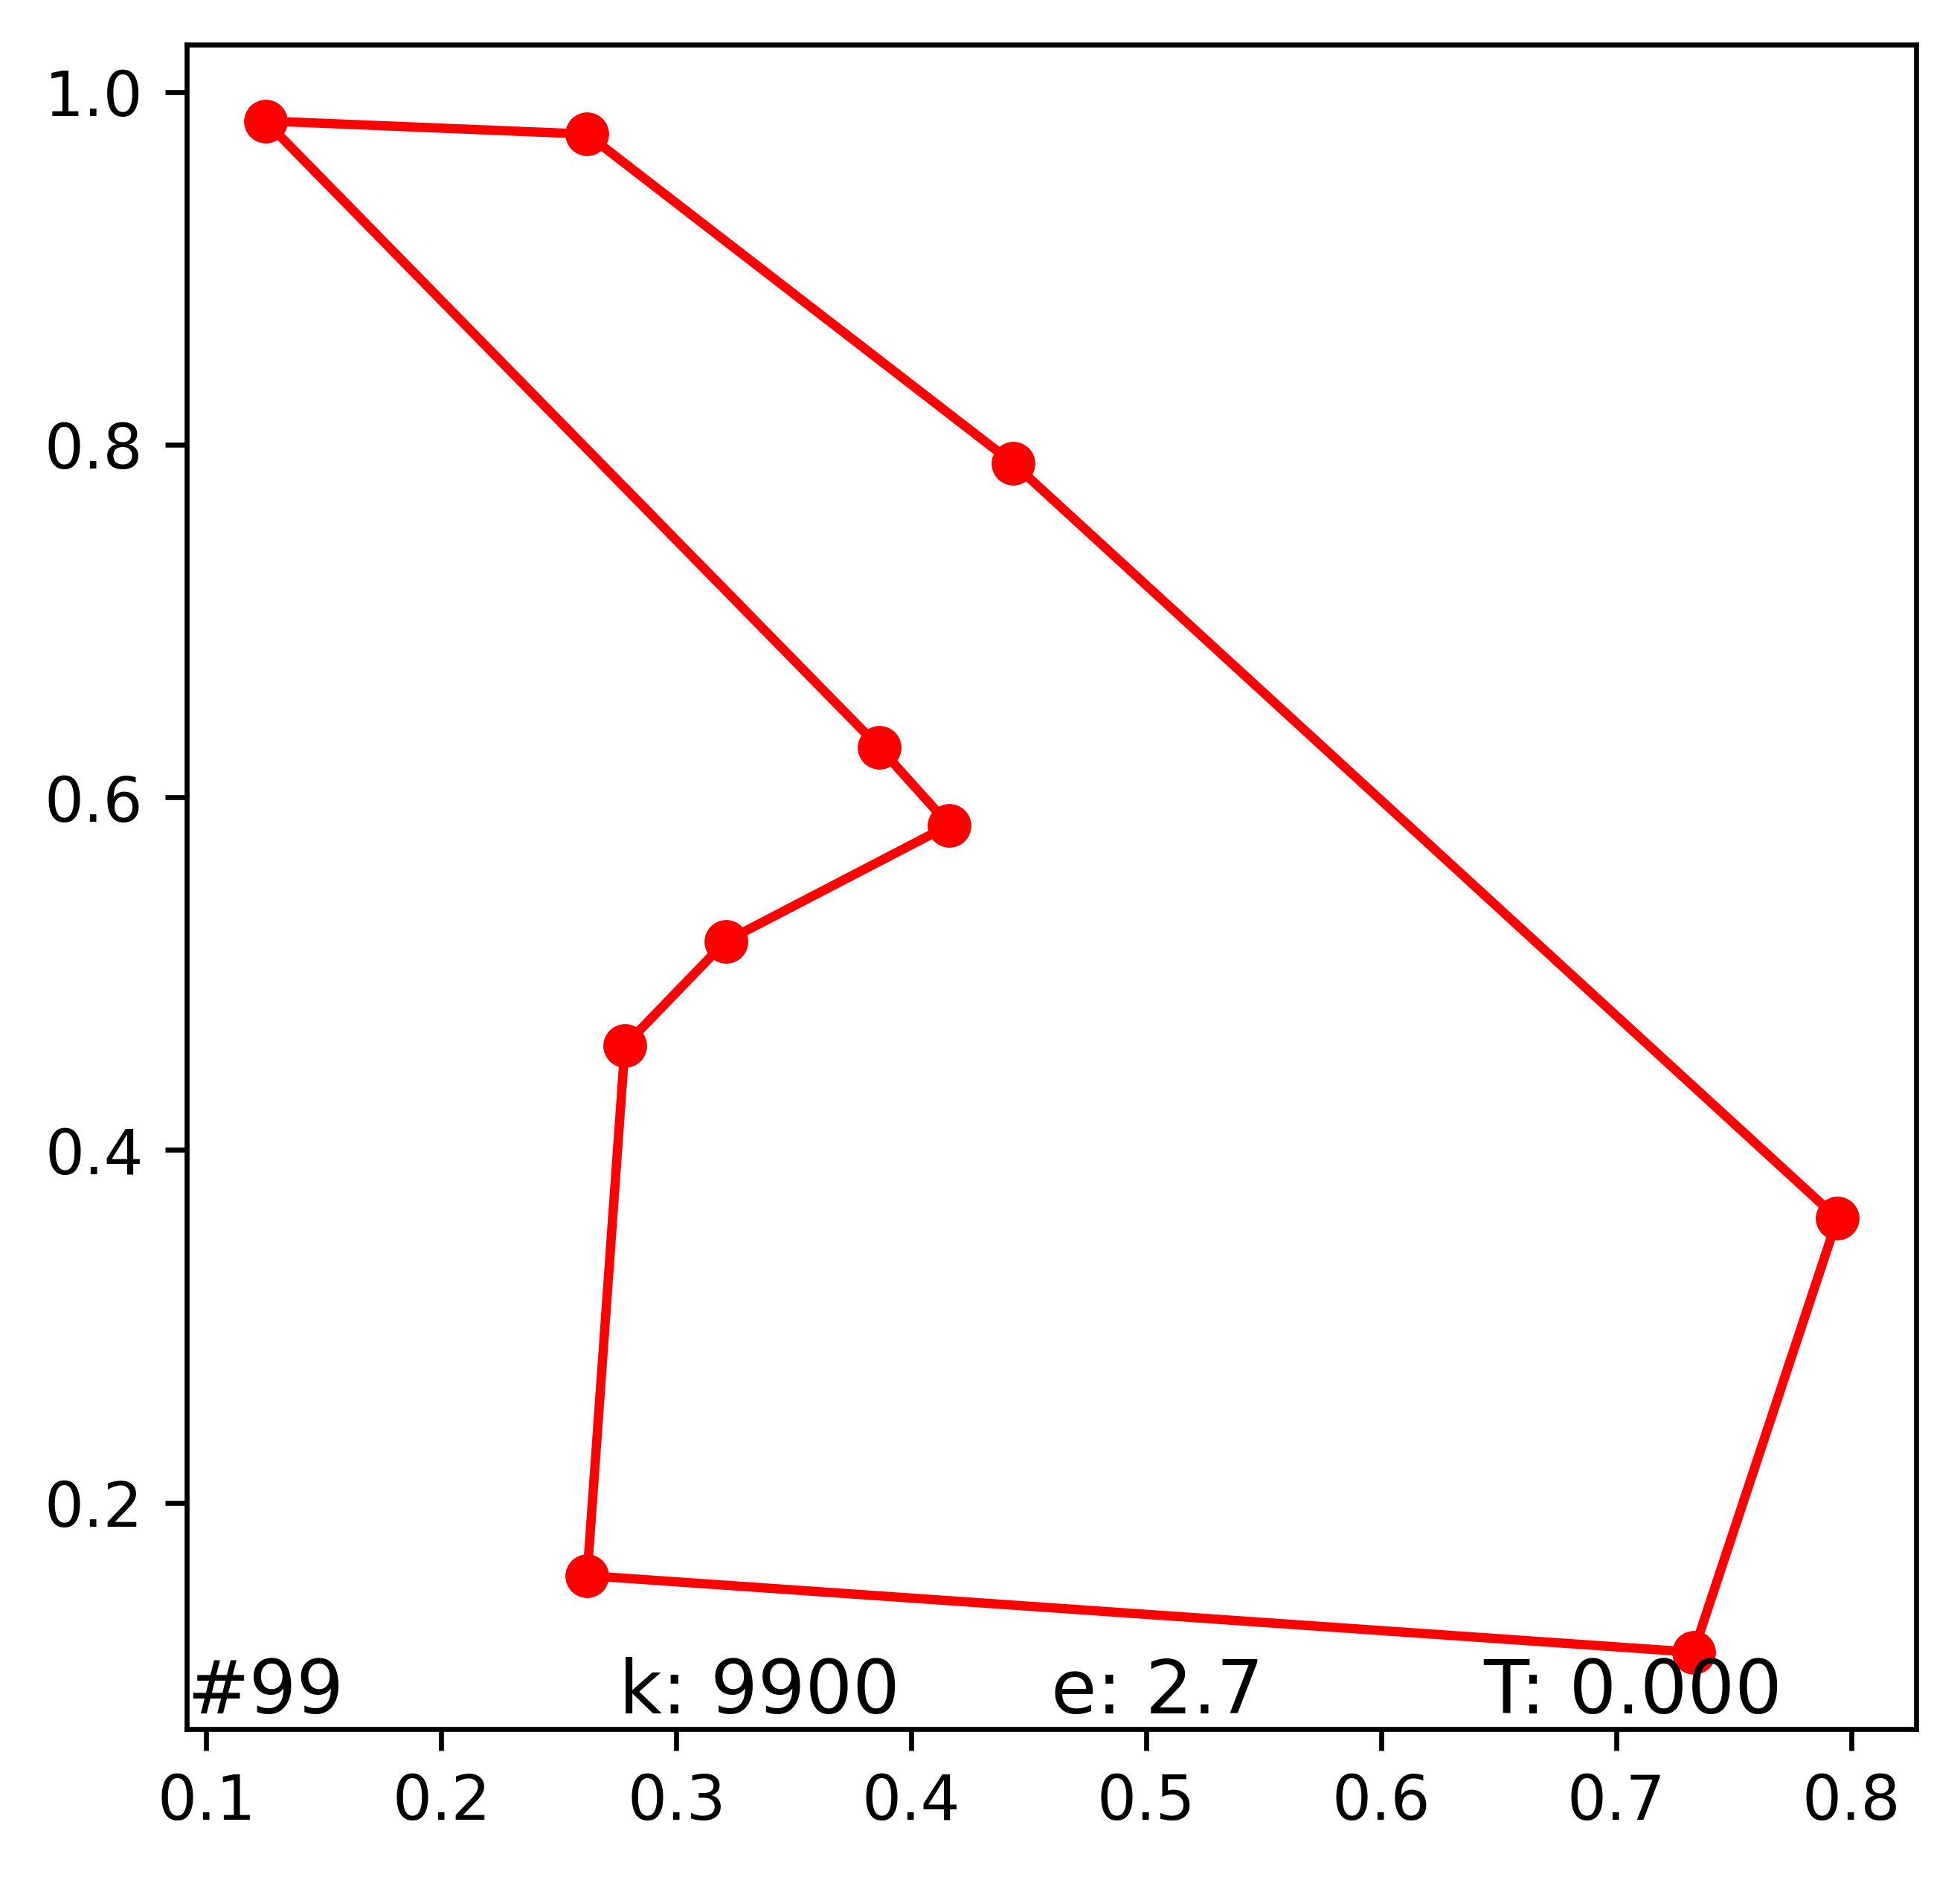

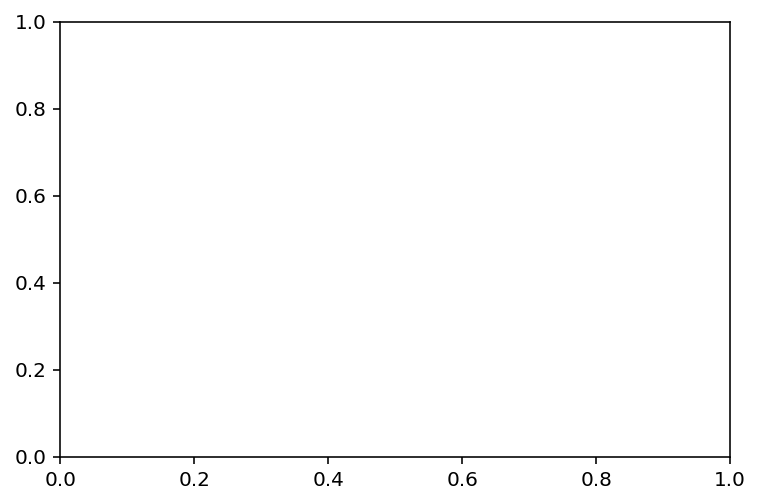

In [17]:
animate_tsp(data_1, output1, name="n-10")

In [ ]:
animate_tsp(data_2, output2, name="n-30")

In [ ]:
animate_tsp(data_3, output21, name="n-50")

In [ ]:
animate_tsp(data_n, output3, name="nd-20")

In [ ]:
animate_tsp(data_g_9, output4, name="groups")

## Conclustions
- Traveling salesman problem is an NP-complete problem.
- Using simulated annealing we can find nearly optimal and acceptable solutions.
- Not always our solution is optimal.

## Additional information
More animations are available in subfolder `tsp`.